# A hierarchical co-clustering approach for entity exploration over Linked Data

## Функции

In [1]:
import rdflib
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def sim_edit(word1, word2):
    return 1 / (1 + editDist(word1, word2))
    
def editDist(word1, word2):
    
    if len(word2) == 0:
        return len(word1)
    
    if len(word1) < len(word2):
        return editDist(word2, word1)
    
    prev = range(len(word2) + 1)
    
    for i, c1 in enumerate(word1):
        this = [i + 1]
        for j, c2 in enumerate(word2):
            ins = prev[j + 1] + 1
            dels = this[j] + 1
            subs = prev[j] + (c1 != c2)
            this.append(min(ins, dels, subs))
        prev = this
        
    return prev[-1]


# def sim_cos(word1, word2):
#     return model.wv.similarity(word1, word2)

#def LCA(word1, word2)

def sim(word1, word2):
    return sim_edit(word1, word2)
    
#def sim_sem(word1, word2)

def cluster_similarity(x_hat, cX, X):
    if True:
        return 0
    
    cl_num = np.unique(np.array(cX).ravel())
    x_cl = np.array(cX).ravel()[x_hat]
    tmp = np.array(cX).ravel()
    x_words = X[tmp == x_cl]
    res = 0
    
    for num in cl_num:
        if num != x_cl:
            other_words = X[tmp == num]
            for word1 in x_words:
                for word2 in other_words:
                    res += sim(word1, word2)
    return res


def cluster_index(cluster, labels):
    num = np.unique(cluster)

    sigma = 0
    
    for i in num:
        sigma_cur = 0
        x = labels[cluster == i]
        for l1 in x:
            for l2 in x:
                if l1 != l2:
                    sigma_cur += sim(l1, l2)
        
        sigma_cur = sigma_cur / (len(x) * (len(x) - 1) + 0.000001)
        sigma += sigma_cur
    
    sigma /= len(num)
    
    delta = 0
    
    for i in num:
        for j in num:
            delta_cur = 0
            if i != j:
                x = labels[cluster == i]
                y = labels[cluster == j]
                for l1 in x:
                    for l2 in y:
                        delta_cur += sim(l1, l2)
                delta_cur = delta_cur / (len(x) * len(y) + 0.000001)
                delta += delta_cur
                
    delta = delta * 2 / (len(num) * (len(num) - 1) + 0.000001)
    
    return sigma **2 / (sigma + delta)

In [3]:
def prob_clust_Indiv(p, xhat, cX, yhat, cY):
    
    # на вход поступает номер кластера для ссылки и класса пара (i, j) с индексами из cx, cy, то есть cx[i], cy[j]
    # смотрим, какие ссылки и классы попали в один кластер и складываем вероятности из совместного распределения
    # как бы смотрим на те ячейки, где определенный кластер ссылок и кластер классов и находим совместное распределение этих кластеров
    
#     print('prob_clust_Indiv p, xhat, cX, yhat, cY', p, xhat, cX, yhat, cY)
#     print('prob_clust_Indiv', np.sum( p[np.array(cX==xhat).ravel(),:][:,np.array(cY==yhat).ravel()] ))
    return np.sum( p[np.array(cX==xhat).ravel(),:][:,np.array(cY==yhat).ravel()] )


def prob_clust(p, Xhat, cX, Yhat, cY):
    output = np.empty([len(Xhat), len(Yhat)],dtype=float)  
    for xhat in Xhat:
        for yhat in Yhat:
            output[xhat, yhat] = prob_clust_Indiv(p, xhat,cX, yhat,cY)
    return output


def prob_x_given_xhat(p, x, xhat, cX):
    #считаем условную вероятность i-я ссылка попала в какой-то кластер
    # p(x|x_hat) = p(x пересечение x_hat) / p(x_hat)
    
    # у нас есть какое-то распределение на кластера cX (это hat)
    # мы берем ссылку и смотрим ее вероятность / вероятность кластера
    # сумма строки / сумма всех строк этого кластера (куда попала эта строка)
    
#     print('prob_x_given_xhat')
#     print(np.sum(p[x,:]))
#     print(np.sum(p[np.array(cX==xhat).ravel(),:]))
    return  np.sum(p[x,:]) / np.sum(p[np.array(cX==xhat).ravel(),:])   #

def prob_y_given_yhat(p ,y, yhat, cY):
    
    # по столбцам то же самое
    
#     print('prob_y_given_yhat')
#     print(np.sum(p[:,y]))
#     print(np.sum(p[:,np.array(cY==yhat).ravel()]))
    return  np.sum(p[:,y]) / np.sum(p[:,np.array(cY==yhat).ravel()])   #  

def prob_Y_given_x(p, x):
    # делим сточку (то етсь ссылку) на сумму в этой строке (то есть смотрим вероятность по всем y)
    # смотрим для конкретной сслыки вероятность всех классов
    return p[x,:] / np.sum(p[x,:])

def prob_X_given_y(p, y):
    return p[:,y] / np.sum(p[:,y])



def calc_q_Indiv(p, x,cX, y,cY):
    return prob_clust_Indiv(p, cX[0,x],cX, cY[0,y], cY) * prob_x_given_xhat(p, x, cX[0,x],cX) * prob_y_given_yhat(p, y, cY[0,y],cY)


def calc_q(p, X, cX, Y, cY):
    output = np.empty([len(X), len(Y)],dtype=float)
    for x in X:
        for y in Y:
#             print('calc_q', x, y)
            # передаем всевозможные пары индексов (i, j)
            output[x,y] = calc_q_Indiv(p, x,cX, y,cY)
#     print('calq_q', output)
    return output



def prob_Y_given_xhat(p, xhat,cX):
    
    # строка / сумма всех строк этого кластера (куда попала эта строка)  и потом суммируем по столбцам
    
    return  np.sum(  p[np.array(cX==xhat).ravel(),:]  /  np.sum(p[np.array(cX==xhat).ravel(),:])  , axis=0 ) 
         
def prob_X_given_yhat(p, yhat,cY):
    return   np.sum (p[:,np.array(cY==yhat).ravel()]  /  np.sum(p[:,np.array(cY==yhat).ravel()])  ,axis=1 ) 



def kl_divergence(p,q):
    TOLERANCE = 0.00000000000001
    p = np.asmatrix(p, dtype=np.float)
    q = np.asmatrix(q, dtype=np.float)
    S=0
    m = np.shape(p)[0]
    n = np.shape(p)[1]
    for i in range(0,m):
         for j in range(0,n):
            kl=(p[i,j]+TOLERANCE) / (q[i,j]+TOLERANCE)  #+TOLERANCE
            S=S+ (p[i,j]*np.log2(kl))       
    return S

    


def next_cx(p,q, x, cX, k, X):
    q_dist_xhat = np.empty(k)
    p_dist_x = prob_Y_given_x(p,x)

    for xhat in range(0,k):
        q_dist_xhat[xhat] = kl_divergence( p_dist_x.ravel(), prob_Y_given_xhat(q, xhat,cX).ravel()  ) + cluster_similarity(xhat, cX, X)
        #print(q_dist_xhat)
    return np.argmin(q_dist_xhat)   #

def next_cX(p,q, cX, k, X):
    output = np.empty(np.shape(cX)[1])
    for x in range(0,np.shape(cX)[1]):
        #print(x)
        output[x] = next_cx(p,q, x,cX, k, X) 
    return output

def next_cy(p,q, y,cY, l, Y):
    q_dist_yhat = np.empty(l)
    p_dist_y = prob_X_given_y(p,y)
    for yhat in range(0,l):
        q_dist_yhat[yhat] = kl_divergence( p_dist_y.ravel(), prob_X_given_yhat(q, yhat, cY).ravel()  )  + cluster_similarity(yhat, cY, Y)
    return np.argmin(q_dist_yhat)


def next_cY(p,q, cY, l, Y):
    output = np.empty(np.shape(cY)[1])
    for y in range(0,np.shape(cY)[1]):
        output[y] = next_cy(p,q, y, cY, l, Y)
    return output
    
    
    
def sorting(p,k,l,cX,cY):
    m = np.shape(p)[0]
    n = np.shape(p)[1]
    M=np.empty((1,n))
    M=np.delete(M, (0), axis=0)

    for i in range(0,k):
    #ind=cX[np.array(cX==i)]
        indexes=[]
        indexes =np.where(cX==i)
        a=p[indexes[1],:]
        M=np.vstack([M,a])

    M1=np.empty((m,1))
    M1=np.delete(M1, (0), axis=1) 
        
    for j in range(0,l):
    #ind=cX[np.array(cX==i)]
        indexes=[]
        indexes =np.where(cY==j)
        a=M[:,indexes[1]]
        M1=np.hstack([M1,a]) 
        
    return M1 

In [4]:
def ITCC(p, k, l, n_iters, convergeThresh, cX, cY, X, Y):

    m = np.shape(p)[0]
    n = np.shape(p)[1]
    
    converged = False

    kl_curr = 0.0
    kl_prev = 0.0
    

    
    q = calc_q(p, range(0,m), cX, range(0,n), cY)
    kl_curr = kl_divergence(p.ravel(), q.ravel())
    Error=[kl_curr] 

    for i in range(0,n_iters):
        print("iteration:\t", i, "\t KL Divergence:\t ",kl_curr)   
        kl_prev = kl_curr
    # Update cX, q
        
        cX = np.matrix (next_cX(p,q, cX, k, X) )
        q = calc_q(p, range(0,m), cX, range(0,n), cY)

    # Update cY, q
        cY = np.matrix (next_cY(p,q, cY, l, Y) )
        q = calc_q(p, range(0,m), cX, range(0,n), cY)
    
        kl_curr = kl_divergence(p.ravel(), q.ravel())
        Error.append(kl_curr)
    
        
        #print(1)
        if abs(kl_prev - kl_curr) < convergeThresh: #& ((kl_prev - kl_curr) >0 ):
            converged = True
            break
            
    M1=sorting(p,k,l,cX,cY)      
    clustered=prob_clust(M1, range(0,k),cX, range(0,l),cY)     
    return(M1,q,cX,cY,clustered,Error)

In [5]:
def hierarchy(navigation_graph, cnt, CH, X, Y):
#     CH = {} # иерархия классов
    p = joint_probability(navigation_graph[(navigation_graph['links'].isin(X.values)) & (navigation_graph['classes'].isin(Y.values))], X.values, Y.values)
#     X = p.index
#     Y = p.columns
#     print(p.values)
#     print(p)
    if np.sum(p.values) == 0:
#         CH[cnt - 1].append('LEAF')
#         print('NAN p', np.sum(p.values))
        return CH, cnt
    
    k = 2
    l = 2
    n_iters = 10
    convergeThresh = 0.00001
    
#     print(p)
#     np.random.seed(42)

    cX = np.matrix(np.random.randint(k, size=p.shape[0]))
    cY = np.matrix(np.random.randint(l, size=p.shape[1]))
    
#     print(p.values)
    
    M1,q,cX,cY,clustered,Error = ITCC(p.values, k, l, n_iters, convergeThresh, cX, cY, X, Y) 
    
#     print('cnt', cnt)
#     print('cx', cX)
#     print('cy', cY)
#     print('X', X)
#     print('Y', Y)
    
    CH[cnt] = [cX, cY, X, Y]
    
    if len(set(np.array(cX).ravel()) & set(np.array(cY).ravel())) == 0:
#         print('set')
        CH[cnt].append('LEAF')
        return CH, cnt
    
    
#     CH[cnt] = [cX, cY, X, Y]
    
    left_x = np.array(cX==0).ravel()
    left_y = np.array(cY==0).ravel()
    
    right_x = np.array(cX==1).ravel()
    right_y = np.array(cY==1).ravel()
    
#     print('left', X[left_x], Y[left_y])
#     print('right', X[right_x], Y[right_y])
    
#     print('left_x', left_x)
#     print(' X[left_x]',  X[left_x])
    
    if np.sum(left_x) != 0 and np.sum(left_y) != 0 and np.sum(left_x) != len(left_x) and np.sum(left_y) != len(left_y):
#     if np.sum(left_x) != 0 and np.sum(left_y) != 0:
        CH, cnt = hierarchy(navigation_graph, cnt + 1, CH, X[left_x], Y[left_y])
    else:
        CH[cnt].append('LEAF')
    if np.sum(right_x) != 0 and np.sum(right_y) != 0 and np.sum(right_x) != len(right_x) and np.sum(right_y) != len(right_y):
#     if np.sum(right_x) != 0 and np.sum(right_y) != 0:
        CH, cnt = hierarchy(navigation_graph, cnt + 1, CH, X[right_x], Y[right_y])
#     else:
#         CH[cnt].append('LEAF')

    
    return CH, cnt

In [6]:
def build_navigation_graph(entity: str): #entity - это как спилберг
    
    classes_links = ['http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 
                     'http://www.w3.org/ns/prov#wasDerivedFrom',
                     'http://www.w3.org/2000/01/rdf-schema#range',
                     'http://www.w3.org/2000/01/rdf-schema#domain',
                     'http://www.w3.org/2000/01/rdf-schema#subPropertyOf',
                     'http://www.w3.org/2000/01/rdf-schema#subClassOf',
                     'http://www.w3.org/2002/07/owl#equivalentClass',
                     'http://www.w3.org/2002/07/owl#equivalentProperty',
                     'http://www.w3.org/2002/07/owl#disjointWith']    # это ссылки, которые могут вести на класс после linked entities
    
    tmp_df = df[df[0] == entity]
    links = tmp_df[tmp_df[1].isin(classes_links)][1].unique()   # ссылки, которые от него идут
    linked_entities = tmp_df[tmp_df[1].isin(classes_links)][2].unique()  # связные сущности
    classes = df[(df[0].isin(linked_entities)) & (df[1].isin(classes_links))][2].to_numpy()  # по ссылкам от linked_entities идем к классам
    
    tmp_df2 = df[(df[1].isin(links)) & (df[2].isin(linked_entities))][[1, 2]].rename(columns = {1:'links', 2: 'linked_entities'}).drop_duplicates()
    tmp_df3 = df[(df[0].isin(linked_entities)) & (df[2].isin(classes))][[0, 2]].rename(columns = {0:'linked_entities', 2:'classes'}).drop_duplicates()
    navigation_graph = tmp_df2.merge(tmp_df3, on = 'linked_entities')
    
    return links, linked_entities, classes, navigation_graph

In [7]:
def joint_probability(navigation_graph, links = None, classes = None):
    
    if len(navigation_graph) == 0:
        p = pd.DataFrame()
        for l in links:
            for c in classes:
                p.loc[l, c] = 0
        return p
    
    return pd.crosstab(navigation_graph['links'], navigation_graph['classes']) / navigation_graph['linked_entities'].nunique()    

In [8]:
def create_sub_graph(root, depth):
    # Limit number of hasWords relations to not overcrowd the figure
    words_cntr = 0
    
    # Get all the triples that are maximally 2 hops away from our randomly picked paper
    objects = set()
    nx_graph = nx.DiGraph()
    
    rdf_subgraph = rdflib.Graph()
    to_explore = {root}
    for _ in range(depth):
        new_explore = set()
        for node in to_explore:
            for s, p, o in g.triples((node, None, None)):
                if 'words' in str(p).lower():
                    if words_cntr >= 25:
                        continue
                    words_cntr += 1

                s_name = str(s).split('/')[-1][:25]
                p_name = str(p).split('/')[-1][:25]
                o_name = str(o).split('/')[-1][:25]
                nx_graph.add_node(s_name, name=s_name)
                nx_graph.add_node(o_name, name=o_name)
                nx_graph.add_edge(s_name, o_name, name=p_name)
                rdf_subgraph.add((s, p, o))
                
                new_explore.add(o)
        to_explore = new_explore
    return nx_graph, rdf_subgraph
    

## Загрузка данных

Используются датасеты с DbPedia [2016 года](http://downloads.dbpedia.org/2016-10/) и последние релизы [2020-22 годов](http://wikidata.dbpedia.org/develop/datasets/latest-core-dataset-releases)

In [9]:
def stripe(x):
    while True:
        if x[-1] in [' ', '.', '"', '<', '>']:
            x = x[:-1]
        else:
            break
    return x

In [10]:
# df = pd.read_csv('dbpedia_2016-10.nt', sep = '> ', header = None)
df = pd.read_csv('ontology--DEV_type=parsed.nt', sep = '> ', header = None)
df.drop(3, axis = 1, inplace = True)
df[0] = df[0].apply(lambda x: x[1:])
df[1] = df[1].apply(lambda x: x[1:])
df[2] = df[2].apply(lambda x: x[1:])
df[2] = df[2].apply(stripe)



In [11]:
df.head()

,0,1,2
0,http://dbpedia.org/ontology/,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#Ontology
1,http://dbpedia.org/ontology/,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://purl.org/vocommons/voaf#Vocabulary
2,http://dbpedia.org/ontology/,http://purl.org/vocab/vann/preferredNamespaceP...,dbo
3,http://dbpedia.org/ontology/,http://purl.org/vocab/vann/preferredNamespaceUri,http://dbpedia.org/ontology/
4,http://dbpedia.org/ontology/,http://purl.org/dc/terms/title,"The DBpedia Ontology""@en"


Виды ссылок

In [12]:
df[1].value_counts()

http://www.w3.org/2000/01/rdf-schema#label             16139
http://www.w3.org/1999/02/22-rdf-syntax-ns#type         8171
http://www.w3.org/ns/prov#wasDerivedFrom                4529
http://www.w3.org/2000/01/rdf-schema#range              2927
http://www.w3.org/2000/01/rdf-schema#domain             2683
http://www.w3.org/2000/01/rdf-schema#comment            2413
http://www.w3.org/2000/01/rdf-schema#subClassOf         1611
http://www.w3.org/2000/01/rdf-schema#subPropertyOf      1027
http://www.w3.org/2002/07/owl#equivalentClass            788
http://www.w3.org/2002/07/owl#equivalentProperty         366
http://www.w3.org/2002/07/owl#disjointWith                55
http://purl.org/vocab/vann/preferredNamespaceUri           1
http://purl.org/dc/terms/title                             1
http://purl.org/dc/terms/description                       1
http://purl.org/dc/terms/source                            1
http://purl.org/dc/terms/publisher                         1
http://purl.org/dc/terms

Представление датасета в виде графа

In [13]:
g = rdflib.Graph()
# g.parse('dbpedia_2016-10.nt', format='nt')
g.parse('ontology--DEV_type=parsed.nt', format='nt')

<Graph identifier=Ncd921d0eea4e4b0e90b1f08254879b06 (<class 'rdflib.graph.Graph'>)>

In [14]:
print('Количество троек:', len(list(g.triples((None, None, None)))))

print('Количество ссылок:', len(set(g.predicates())))

print('Количество сущностей:', len(set(g.subjects())))

Количество троек: 40715
Количество ссылок: 23
Количество сущностей: 5170


In [15]:
example = rdflib.URIRef('http://dbpedia.org/ontology/Dog')
for i, (s, p, o) in enumerate(g.triples((example, None, None))):
    print(s, p, o)

http://dbpedia.org/ontology/Dog http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label hund
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label イヌ
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label Hund
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label chien
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label کتا
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label 개
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label madra
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label hond
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label dog
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#label σκύλος
http://dbpedia.org/ontology/Dog http://www.w3.org/2000/01/rdf-schema#subClassOf http://

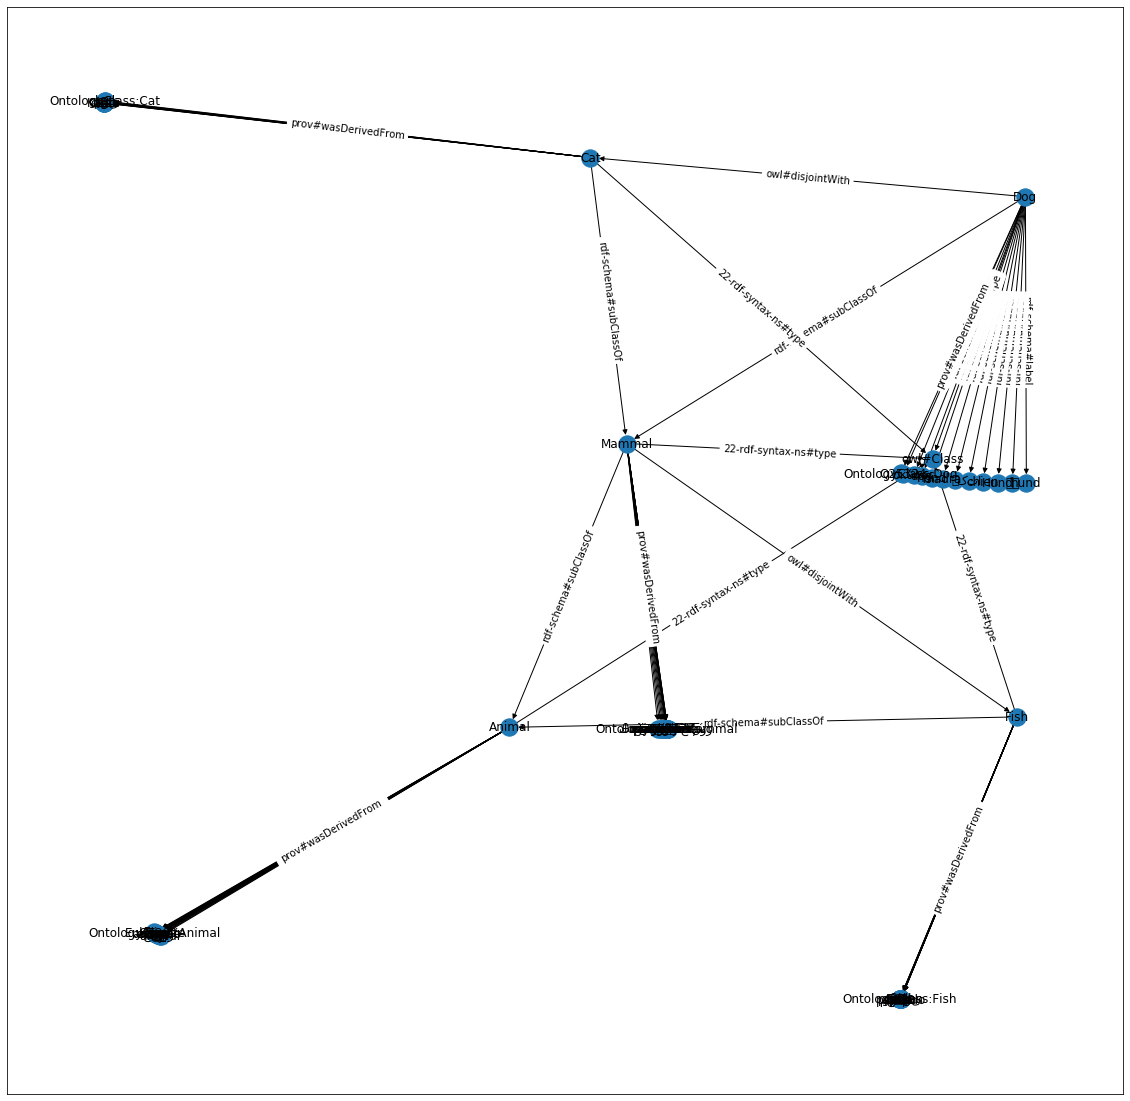

In [16]:
nx_graph, rdf_subgraph = create_sub_graph(example, 3)
        
plt.figure(figsize=(20, 20))
_pos = nx.kamada_kawai_layout(nx_graph)
_ = nx.draw_networkx_nodes(nx_graph, pos=_pos)
_ = nx.draw_networkx_edges(nx_graph, pos=_pos)
_ = nx.draw_networkx_labels(nx_graph, pos=_pos, fontsize=8)
names = nx.get_edge_attributes(nx_graph, 'name')
_ = nx.draw_networkx_edge_labels(nx_graph, pos=_pos, edge_labels=names, fontsize=8)

# rdf_subgraph.serialize(destination='sub.ttl', format='turtle')

## Пример кластеризации

Построим навигационный граф и матрицу совместных вероятностей

In [17]:
links, linked_entities, classes, navigation_graph = build_navigation_graph('http://dbpedia.org/ontology/Dog')

In [18]:
navigation_graph

,links,linked_entities,classes
0,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Mammal,http://www.w3.org/2002/07/owl#Class
1,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Mammal,http://dbpedia.org/ontology/Animal
2,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Mammal,http://www.wikidata.org/entity/Q7377
3,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Mammal,http://dbpedia.org/ontology/Fish
4,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://dbpedia.org/ontology/Mammal,http://mappings.dbpedia.org/index.php/Ontology...
5,http://www.w3.org/2002/07/owl#disjointWith,http://dbpedia.org/ontology/Cat,http://www.w3.org/2002/07/owl#Class
6,http://www.w3.org/2002/07/owl#disjointWith,http://dbpedia.org/ontology/Cat,http://dbpedia.org/ontology/Mammal
7,http://www.w3.org/2002/07/owl#disjointWith,http://dbpedia.org/ontology/Cat,http://www.wikidata.org/entity/Q146
8,http://www.w3.org/2002/07/owl#disjointWith,http://dbpedia.org/ontology/Cat,http://mappings.dbpedia.org/index.php/Ontology...


In [19]:
p = joint_probability(navigation_graph)

In [20]:
p

classes,http://dbpedia.org/ontology/Animal,http://dbpedia.org/ontology/Fish,http://dbpedia.org/ontology/Mammal,http://mappings.dbpedia.org/index.php/OntologyClass:Cat,http://mappings.dbpedia.org/index.php/OntologyClass:Mammal,http://www.w3.org/2002/07/owl#Class,http://www.wikidata.org/entity/Q146,http://www.wikidata.org/entity/Q7377
links,,,,,,,,
http://www.w3.org/2000/01/rdf-schema#subClassOf,0.5,0.5,0.0,0.0,0.5,0.5,0.0,0.5
http://www.w3.org/2002/07/owl#disjointWith,0.0,0.0,0.5,0.5,0.0,0.5,0.5,0.0


Пример без иерархии

In [44]:
k = 2
l = 2
n_iters = 10
convergeThresh = 0.001


cX = np.matrix(np.random.randint(3, size=p.shape[0]))
cY = np.matrix(np.random.randint(2, size=p.shape[1]))

M1,q,cX,cY,clustered,Error = ITCC(p.values, k, l, n_iters, convergeThresh, cX, cY,  p.index, p.columns) 

iteration:	 0 	 KL Divergence:	  3.4273764861365716
iteration:	 1 	 KL Divergence:	  0.8048202372183788


In [46]:
print('Совместное распределение кластеров')
print(clustered)

print('Ссылки')
print(p.index)

print('Номера кластеров для ссылок')
print(cX)

print('Классы')
print(p.columns)

print('Номера кластеров для классов')
print(cY)


Совместное распределение кластеров
[[1.5 1. ]
 [1.  1. ]]
Ссылки
Index(['http://www.w3.org/2000/01/rdf-schema#subClassOf', 'http://www.w3.org/2002/07/owl#disjointWith'], dtype='object', name='links')
Номера кластеров для ссылок
[[1. 0.]]
Классы
Index(['http://dbpedia.org/ontology/Animal',
       'http://dbpedia.org/ontology/Fish',
       'http://dbpedia.org/ontology/Mammal',
       'http://mappings.dbpedia.org/index.php/OntologyClass:Cat',
       'http://mappings.dbpedia.org/index.php/OntologyClass:Mammal',
       'http://www.w3.org/2002/07/owl#Class',
       'http://www.wikidata.org/entity/Q146',
       'http://www.wikidata.org/entity/Q7377'],
      dtype='object', name='classes')
Номера кластеров для классов
[[1. 1. 0. 0. 1. 0. 0. 1.]]


In [47]:
print('Cluster Index (CI) для ссылок', cluster_index(np.array(cX.ravel())[0], np.array(p.index)))
print('Cluster Index (CI) для классов', cluster_index(np.array(cY.ravel())[0], np.array(p.columns)))

Cluster Index (CI) для ссылок 0.0
Cluster Index (CI) для классов 0.011260868941795264


Запустим иерархическую кластеризацию

In [50]:
CH, cnt = hierarchy(navigation_graph, 0, {}, p.index, p.columns)

iteration:	 0 	 KL Divergence:	  3.427376486136572
iteration:	 1 	 KL Divergence:	  0.8048202372183788
iteration:	 0 	 KL Divergence:	  0.0
iteration:	 0 	 KL Divergence:	  0.0


In [51]:
CH

{0: [matrix([[1., 0.]]),
  matrix([[1., 1., 0., 0., 1., 0., 0., 1.]]),
  Index(['http://www.w3.org/2000/01/rdf-schema#subClassOf', 'http://www.w3.org/2002/07/owl#disjointWith'], dtype='object', name='links'),
  Index(['http://dbpedia.org/ontology/Animal',
         'http://dbpedia.org/ontology/Fish',
         'http://dbpedia.org/ontology/Mammal',
         'http://mappings.dbpedia.org/index.php/OntologyClass:Cat',
         'http://mappings.dbpedia.org/index.php/OntologyClass:Mammal',
         'http://www.w3.org/2002/07/owl#Class',
         'http://www.wikidata.org/entity/Q146',
         'http://www.wikidata.org/entity/Q7377'],
        dtype='object', name='classes')],
 1: [matrix([[1.]]),
  matrix([[0., 0., 0., 0.]]),
  Index(['http://www.w3.org/2002/07/owl#disjointWith'], dtype='object', name='links'),
  Index(['http://dbpedia.org/ontology/Mammal',
         'http://mappings.dbpedia.org/index.php/OntologyClass:Cat',
         'http://www.w3.org/2002/07/owl#Class',
         'http://www.wik

Пример из статьи

In [52]:
navigation_graph = pd.DataFrame()

navigation_graph.loc[:, 'links'] = ['executive producer', 'producer', 'producer', 'writer', 'writer', 'birth place', 'resident']
navigation_graph.loc[:, 'linked_entities'] = ['FS', 'MB', 'AI', 'AI', 'MH', 'C', 'LA']
navigation_graph.loc[:, 'classes'] = ['Television Show', 'Film', 'Film', 'Film', 'Video Game', 'City', 'City']


p = joint_probability(navigation_graph)

In [53]:
p

classes,City,Film,Television Show,Video Game
links,,,,
birth place,0.166667,0.000000,0.000000,0.000000
executive producer,0.000000,0.000000,0.166667,0.000000
producer,0.000000,0.333333,0.000000,0.000000
resident,0.166667,0.000000,0.000000,0.000000
writer,0.000000,0.166667,0.000000,0.166667


In [63]:
k = 2
l = 2
n_iters = 10
convergeThresh = 0.001


cX = np.matrix(np.random.randint(3, size=p.shape[0]))
cY = np.matrix(np.random.randint(2, size=p.shape[1]))

M1,q,cX,cY,clustered,Error = ITCC(p.values, k, l, n_iters, convergeThresh, cX, cY,  p.index, p.columns)

iteration:	 0 	 KL Divergence:	  1.1258145836938007
iteration:	 1 	 KL Divergence:	  0.6666666666666088


In [64]:
print('Совместное распределение кластеров')
print(clustered)

print('Ссылки')
print(p.index)

print('Номера кластеров для ссылок')
print(cX)

print('Классы')
print(p.columns)

print('Номера кластеров для классов')
print(cY)


Совместное распределение кластеров
[[0.5        0.16666667]
 [0.33333333 0.16666667]]
Ссылки
Index(['birth place', 'executive producer', 'producer', 'resident', 'writer'], dtype='object', name='links')
Номера кластеров для ссылок
[[0. 0. 1. 0. 1.]]
Классы
Index(['City', 'Film', 'Television Show', 'Video Game'], dtype='object', name='classes')
Номера кластеров для классов
[[0. 1. 0. 1.]]


In [65]:
print('Cluster Index (CI) для ссылок', cluster_index(np.array(cX.ravel())[0], np.array(p.index)))
print('Cluster Index (CI) для классов', cluster_index(np.array(cY.ravel())[0], np.array(p.columns)))

Cluster Index (CI) для ссылок 0.044923786510383194
Cluster Index (CI) для классов 0.023537725070282966


Запустим алгоритм иерархической совместной кластеризации

In [86]:
CH, cnt = hierarchy(navigation_graph, 0, {}, p.index, p.columns)

iteration:	 0 	 KL Divergence:	  1.8091254953786753
iteration:	 1 	 KL Divergence:	  0.8091254953788038
iteration:	 0 	 KL Divergence:	  0.0
iteration:	 0 	 KL Divergence:	  0.999999999999947
iteration:	 1 	 KL Divergence:	  0.3112781244591184
iteration:	 0 	 KL Divergence:	  0.41503749927882927
iteration:	 0 	 KL Divergence:	  0.0


In [87]:
CH

{0: [matrix([[0., 1., 1., 0., 1.]]),
  matrix([[0., 1., 1., 1.]]),
  Index(['birth place', 'executive producer', 'producer', 'resident', 'writer'], dtype='object', name='links'),
  Index(['City', 'Film', 'Television Show', 'Video Game'], dtype='object', name='classes')],
 1: [matrix([[0., 0.]]),
  matrix([[0.]]),
  Index(['birth place', 'resident'], dtype='object', name='links'),
  Index(['City'], dtype='object', name='classes'),
  'LEAF'],
 2: [matrix([[1., 0., 0.]]),
  matrix([[0., 1., 0.]]),
  Index(['executive producer', 'producer', 'writer'], dtype='object', name='links'),
  Index(['Film', 'Television Show', 'Video Game'], dtype='object', name='classes')],
 3: [matrix([[0., 0.]]),
  matrix([[1., 1.]]),
  Index(['producer', 'writer'], dtype='object', name='links'),
  Index(['Film', 'Video Game'], dtype='object', name='classes'),
  'LEAF'],
 4: [matrix([[1.]]),
  matrix([[1.]]),
  Index(['executive producer'], dtype='object', name='links'),
  Index(['Television Show'], dtype='object